▶️ Step 1: Installing MONAI...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 66.9 MB/s eta 0:00:00
✅ Installation complete.

▶️ Step 2: Importing libraries and setting up...


<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-08-12 08:09:50.229228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754986190.447414      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754986190.510363      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


MONAI version: 1.5.0
Numpy version: 1.26.4
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d388d1c6fec8cb3a0eebee5b5a0b9776ca59ca83
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 11.2.1
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: 4.52.4
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#inst

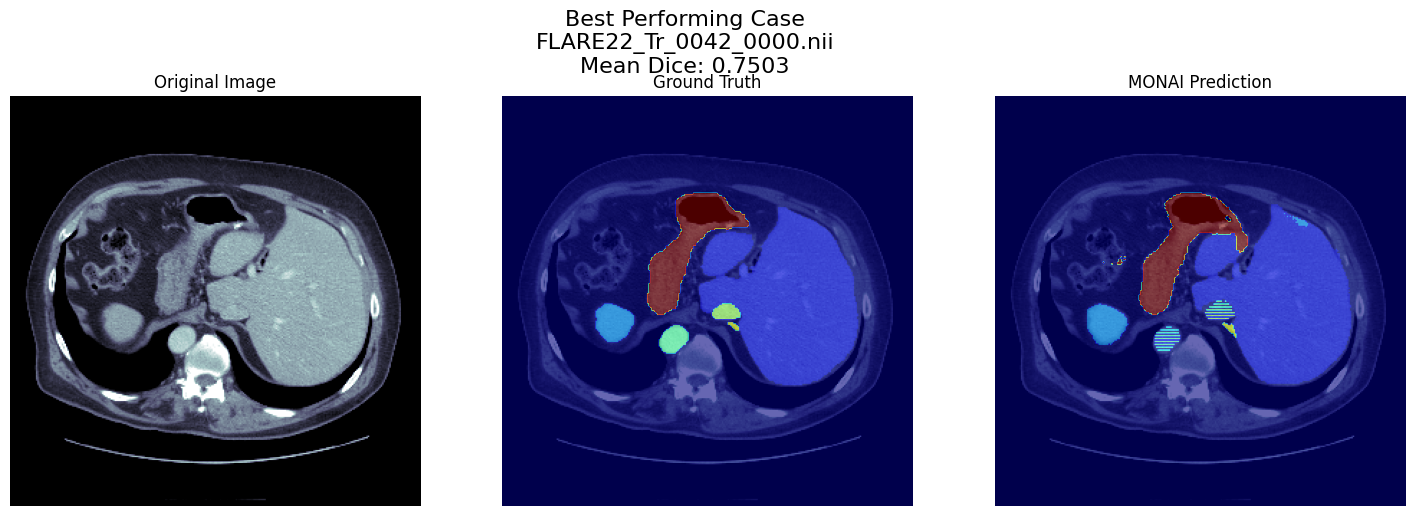

------------------------------
📊 Worst Performing Case: FLARE22_Tr_0041_0000.nii
Mean Dice: 0.5940
Per-Organ Dice Scores:
  - Spleen                : 0.9250
  - Right Kidney          : 0.9317
  - Left Kidney           : 0.9021
  - Gallbladder           : 0.5404
  - Liver                 : 0.5761
  - Stomach               : 0.5487
  - Aorta                 : 0.6328
  - Inferior Vena Cava    : 0.0977
  - Pancreas              : 0.3080
  - Right Adrenal Gland   : 0.6533
  - Left Adrenal Gland    : 0.7593
  - Duodenum              : 0.2197
  - Bladder               : 0.6277


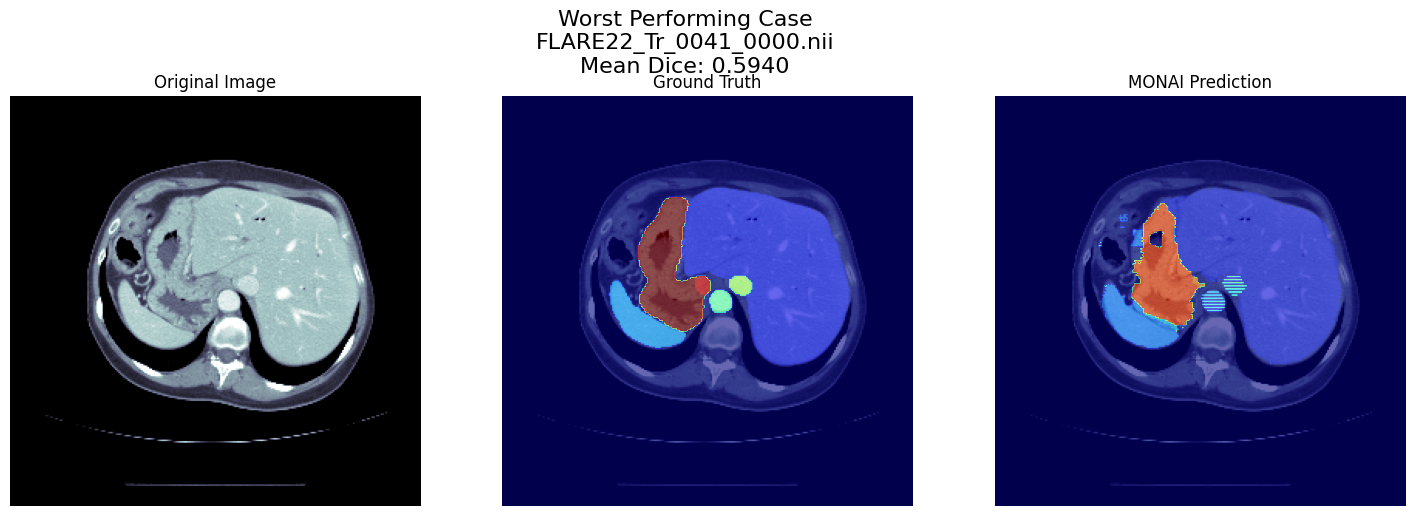


✅ Pipeline complete!


In [1]:
# ==============================================================================
# KAGGLE PIPELINE: FINAL EXPERIMENT - RandAffine + LeakyReLU
# ==============================================================================

print("▶️ Step 1: Installing MONAI...")
!pip install -q "monai[nibabel, tqdm]"
print("✅ Installation complete.")

print("\n▶️ Step 2: Importing libraries and setting up...")
import os
import shutil
import time
from glob import glob

import torch
import monai
import numpy as np
from monai.config import print_config
from monai.data import DataLoader, Dataset, decollate_batch
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandRotate90d,
    RandGaussianNoised,
    ScaleIntensityRanged,
    Spacingd,
    SpatialPadD,
    EnsureTyped,
    # Import for this experiment
    RandAffined,
)
import matplotlib.pyplot as plt

print_config()
print("✅ Setup complete.")

# ==============================================================================
# 2. PREPARE DATASET (WITH DATA INTEGRITY CHECK)
# ==============================================================================
print("\n▶️ Step 3: Preparing Data...")
try:
    output_dir = "/kaggle/working/"
    os.makedirs(output_dir, exist_ok=True)
    print(f"Model checkpoints will be saved to: {output_dir}")

    drive_data_path = "/kaggle/input/flare22train/FLARE22Train"
    images_path = os.path.join(drive_data_path, "images")
    labels_path = os.path.join(drive_data_path, "labels")

    all_images = sorted(glob(os.path.join(images_path, "*.nii")))
    all_labels = sorted(glob(os.path.join(labels_path, "*.nii")))

    print("Verifying data integrity...")
    data_dicts = []
    for img_path, lbl_path in zip(all_images, all_labels):
        if os.path.exists(img_path) and os.path.exists(lbl_path) and os.path.getsize(img_path) > 0 and os.path.getsize(lbl_path) > 0:
            data_dicts.append({"image": img_path, "label": lbl_path})
        else:
            print(f"WARNING: Skipping corrupted or empty file pair: {os.path.basename(img_path)} and {os.path.basename(lbl_path)}")

    if len(data_dicts) == 0:
        raise FileNotFoundError(f"No valid, non-empty image/label pairs found.")

    num_total = len(data_dicts)
    num_train = int(num_total * 0.8)
    train_files, val_files = data_dicts[:num_train], data_dicts[num_train:]
    
    print(f"✅ Data prepared: Found {len(data_dicts)} valid pairs.")
    print(f"   --> {len(train_files)} training files, {len(val_files)} validation files.")
except Exception as e:
    print(f"❌ FATAL ERROR in Data Preparation: {e}")
    raise e

# ==============================================================================
# 3. DEFINE TRANSFORMS, DATASET, AND DATALOADER
# ==============================================================================
print("\n▶️ Step 4: Defining MONAI transforms and dataloaders...")
roi_size = (96, 96, 96)
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
    SpatialPadD(keys=["image", "label"], spatial_size=roi_size, method="end"),
    RandCropByPosNegLabeld(
        keys=["image", "label"], label_key="label", spatial_size=roi_size,
        pos=1, neg=1, num_samples=4, image_key="image", image_threshold=0,
    ),
    # --- COMBINED TWEAK 1: RandAffine Augmentation ---
    RandAffined(
        keys=['image', 'label'],
        mode=('bilinear', 'nearest'),
        prob=0.2, 
        rotate_range=(0, 0, np.pi/15),
        scale_range=(0.1, 0.1, 0.1),
        padding_mode="border",
    ),
    RandRotate90d(keys=["image", "label"], prob=0.10, max_k=3),
    RandGaussianNoised(keys="image", prob=0.10, mean=0.0, std=0.1),
    EnsureTyped(keys=["image", "label"]),
])
val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image", "label"]),
])

train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)
val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)
print("✅ Dataloaders ready.")

# ==============================================================================
# 4. SET UP MODEL, LOSS, AND OPTIMIZER
# ==============================================================================
print("\n▶️ Step 5: Setting up Model, Loss, and Optimizer...")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3, in_channels=1, out_channels=14,
    channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2),
    num_res_units=2,
    # --- COMBINED TWEAK 2: LeakyReLU Activation ---
    act="leakyrelu",
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean_batch")
organ_names = [
    "Spleen", "Right Kidney", "Left Kidney", "Gallbladder", "Liver", "Stomach",
    "Aorta", "Inferior Vena Cava", "Pancreas", "Right Adrenal Gland",
    "Left Adrenal Gland", "Duodenum", "Bladder"
]
print("✅ Model setup complete.")


# ==============================================================================
# 5. TRAINING LOOP
# ==============================================================================
print("\n▶️ Step 6: Starting Training...")
max_epochs = 100
val_interval = 2
best_metric = -1
best_metric_epoch = -1
post_pred = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=14)])
post_label = Compose([AsDiscrete(to_onehot=14)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    if len(train_loader) == 0: break
    for batch_data in train_loader:
        step += 1
        inputs, labels = (batch_data["image"].to(device), batch_data["label"].to(device))
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step*train_loader.batch_size}/{len(train_ds)}, train_loss: {loss.item():.4f}", end="\r")

    epoch_loss /= step
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0 and len(val_loader) > 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (val_data["image"].to(device), val_data["label"].to(device))
                val_outputs = sliding_window_inference(val_inputs, roi_size, 4, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)

            metric_batch = dice_metric.aggregate()
            metric = metric_batch.mean().item()
            dice_metric.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(output_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(f"current epoch: {epoch + 1} current mean dice: {metric:.4f}")
            print("Per-organ Dice scores:")
            for i, name in enumerate(organ_names):
                print(f"  - {name:<22}: {metric_batch[i].item():.4f}")
            print(f"best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")

print(f"\n✅ Training complete. Best mean dice: {best_metric:.4f} at epoch {best_metric_epoch}")


# ==============================================================================
# 6. ENHANCED VISUALIZATION
# ==============================================================================
print("\n▶️ Step 7: Evaluating and Visualizing Results...")
best_model_path = os.path.join(output_dir, "best_metric_model.pth")

if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    model.eval()

    validation_mean_scores = {}
    validation_organ_scores = {}

    with torch.no_grad():
        for i, val_data in enumerate(val_loader):
            val_inputs = val_data["image"].to(device)
            val_labels = val_data["label"].to(device)
            val_outputs = sliding_window_inference(val_inputs, roi_size, 4, model)
            val_outputs_post = [post_pred(i) for i in decollate_batch(val_outputs)]
            val_labels_post = [post_label(i) for i in decollate_batch(val_labels)]
            dice_metric(y_pred=val_outputs_post, y=val_labels_post)
            organ_scores = dice_metric.aggregate()
            mean_score = organ_scores.mean().item()
            dice_metric.reset()
            case_name = os.path.basename(val_files[i]['image'])
            validation_mean_scores[case_name] = mean_score
            validation_organ_scores[case_name] = organ_scores.cpu().numpy()

    sorted_scores = sorted(validation_mean_scores.items(), key=lambda item: item[1])
    best_case_name, best_score = sorted_scores[-1]
    worst_case_name, worst_score = sorted_scores[0]

    def plot_and_report_case(case_dict, title, mean_dice, organ_dice):
        case_name = os.path.basename(case_dict['image'])
        print("-" * 30)
        print(f"📊 {title}: {case_name}")
        print(f"Mean Dice: {mean_dice:.4f}")
        print("Per-Organ Dice Scores:")
        for i, name in enumerate(organ_names):
            print(f"  - {name:<22}: {organ_dice[i]:.4f}")

        with torch.no_grad():
            transformed_data = val_transforms(case_dict)
            val_input = transformed_data['image'].unsqueeze(0).to(device)
            val_output = sliding_window_inference(val_input, roi_size, 4, model)
            val_output_processed = torch.argmax(val_output, dim=1).detach().cpu().numpy()[0, :, :, :]
            
            ground_truth = transformed_data['label'][0, :, :, :].numpy()
            original_image = transformed_data['image'][0, :, :, :].numpy()
            slice_idx = np.argmax(np.sum(ground_truth, axis=(0, 1)))

            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            fig.suptitle(f"{title}\n{case_name}\nMean Dice: {mean_dice:.4f}", fontsize=16)
            axes[0].imshow(np.rot90(original_image[:, :, slice_idx]), cmap="bone"); axes[0].set_title("Original Image"); axes[0].axis('off')
            axes[1].imshow(np.rot90(original_image[:, :, slice_idx]), cmap="bone"); axes[1].imshow(np.rot90(ground_truth[:, :, slice_idx]), cmap="jet", alpha=0.6); axes[1].set_title("Ground Truth"); axes[1].axis('off')
            axes[2].imshow(np.rot90(original_image[:, :, slice_idx]), cmap="bone"); axes[2].imshow(np.rot90(val_output_processed[:, :, slice_idx]), cmap="jet", alpha=0.6); axes[2].set_title("MONAI Prediction"); axes[2].axis('off')
            plt.show()

    best_case_dict = next(item for item in val_files if best_case_name in item["image"])
    worst_case_dict = next(item for item in val_files if worst_case_name in item["image"])
    
    best_organ_scores = validation_organ_scores[best_case_name]
    worst_organ_scores = validation_organ_scores[worst_case_name]

    plot_and_report_case(best_case_dict, "Best Performing Case", best_score, best_organ_scores)
    plot_and_report_case(worst_case_dict, "Worst Performing Case", worst_score, worst_organ_scores)
else:
    print("Evaluation skipped because no model was saved.")

print("\n✅ Pipeline complete!")